In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import MaxNLocator
from matplotlib.transforms import Affine2D
from scipy.integrate import quad as quad
import sys
sys.path.insert(0, "/scratch/ierez/IGMCosmo/VoidFinder/python/")
#import voidfinder
#from voidfinder import distance
#from voidfinder.distance import z_to_comoving_dist
from astropy import constants as const
from astropy.table import Table

import os
from astropy.io import fits
in_directory='/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/'
os.chdir(in_directory)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator, MaxNLocator, DictFormatter

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value
from astropy import constants as const

from scipy.integrate import quad as quad
from scipy.spatial import cKDTree, ConvexHull

from sympy import solve_poly_system, im
from sympy.abc import x,y

matplotlib.rcParams.update({'font.size': 38})

## Data files

In [3]:
deltafields_filename = '/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/deltafields_RAadded90.fits' #delta_fields
quasars_filename='/scratch/ierez/IGMCosmo/VoidFinder/data/DR16S82_H/delta_fields/quasars.fits'
#void_filename = '/Users/kellydouglass/Documents/Research/Voids/VoidFinder/void_catalogs/SDSS/python_implementation/vollim_dr7_cbp_102709_comoving_maximal.txt'
void_filename = '/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/before_names/deltafields_RAadded90._comoving_maximal_noMagCut.txt'

In [4]:

vfdata = Table.read('/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/old/before_merge/deltafields_RAadded90._comoving_maximal_noMagCut.txt',format='ascii.commented_header')
#VoidFinder hole output
vfdata2 = Table.read('/scratch/ierez/IGMCosmo/VoidFinder/outputs/delta_runs/old/before_merge/deltafields_RAadded90._comoving_holes_noMagCut.txt',format='ascii.commented_header')


In [5]:
D2R = np.pi/180.

def toSky(cs):
    c1  = cs.T[0]
    c2  = cs.T[1]
    c3  = cs.T[2]
    r   = np.sqrt(c1**2.+c2**2.+c3**2.)
    dec = np.arcsin(c3/r)/D2R
    ra  = (np.arccos(c1/np.sqrt(c1**2.+c2**2.))*np.sign(c2)/D2R)%360
    return r,ra,dec

def toCoord(r,ra,dec):
    c1 = r*np.cos(ra*D2R)*np.cos(dec*D2R)
    c2 = r*np.sin(ra*D2R)*np.cos(dec*D2R)
    c3 = r*np.sin(dec*D2R)
    return c1,c2,c3

In [6]:
# Galaxy catalog
#galaxies = Table.read(galaxy_filename, format='ascii.commented_header', 
#                      include_names=['ra', 'dec', 'redshift', 'Rgal', 'vflag'])
deltaf = fits.open(deltafields_filename)  
deltaf=Table(deltaf[1].data)
deltaf['z'].name='redshift'
#rgal=Table.Column(1*np.ones(len(galaxies['ra'])), name='Rgal')
#galaxies.add_column(rgal)
vflag=Table.Column(np.zeros(len(deltaf['ra'])), name='vflag')
deltaf.add_column(vflag)
# Void catalog (detected voids, output of voidfinder)
#voids = Table.read(void_filename, format='ascii.commented_header')

quasars = fits.open(quasars_filename)  
quasars=Table(quasars[1].data)



def toCoord(r,ra,dec):
    c1 = r*np.cos(ra*D2R)*np.cos(dec*D2R)
    c2 = r*np.sin(ra*D2R)*np.cos(dec*D2R)
    c3 = r*np.sin(dec*D2R)
    return c1,c2,c3

#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

deltaf['comoving']= Distance(deltaf['redshift'],Omega_M,1)
quasars['comoving']= Distance(quasars['z'],Omega_M,1)
#Continue with voids['r']


dx,dy,dz=toCoord(deltaf['comoving'],deltaf['ra'],deltaf['dec'])
dr=deltaf['comoving']
ddec=deltaf['dec']
dra=deltaf['ra']
qra=quasars['ra']
qr=quasars['comoving']
qra=qra+90

In [7]:
min(qra)

47.00374690949121

In [8]:
vfx = vfdata['x']
vfy = vfdata['y']
vfz = vfdata['z']
vfr,vfra,vfdec = toSky(np.array([vfx,vfy,vfz]).T)
vfrad = vfdata['radius']
vfc  = matplotlib.cm.nipy_spectral(np.linspace(0,1,len(vfr)))
vfcc = np.random.choice(range(len(vfc)),len(vfc),replace=False)

vflag = vfdata2['flag']
vfx2 = vfdata2['x']
vfy2 = vfdata2['y']
vfz2 = vfdata2['z']
vfr1,vfra1,vfdec1 = toSky(np.array([vfx2,vfy2,vfz2]).T)
vfrad1 = vfdata2['radius']
vfx4   = [vfx2[vflag==vfl] for vfl in np.unique(vflag)]
vfy4   = [vfy2[vflag==vfl] for vfl in np.unique(vflag)]
vfz4   = [vfz2[vflag==vfl] for vfl in np.unique(vflag)]
vfr2   = [vfr1[vflag==vfl] for vfl in np.unique(vflag)]
vfra2  = [vfra1[vflag==vfl] for vfl in np.unique(vflag)]
vfdec2 = [vfdec1[vflag==vfl] for vfl in np.unique(vflag)]
vfrad2 = [vfrad1[vflag==vfl] for vfl in np.unique(vflag)]

gflag_vf = np.zeros(len(dx),dtype=bool)
#gflag_v2 = np.zeros(len(dx),dtype=bool)

kdt = cKDTree(np.array([dx,dy,dz]).T)

for vfl in np.unique(vflag):
    vfx3 = vfx2[vflag==vfl]
    vfy3 = vfy2[vflag==vfl]
    vfz3 = vfz2[vflag==vfl]
    vfrad3 = vfrad1[vflag==vfl]
    for i in range(len(vfx3)):
        galinds = kdt.query_ball_point([vfx3[i],vfy3[i],vfz3[i]],vfrad3[i])
        gflag_vf[galinds] = True

#for z in range(len(z_v)):
#    if z_v[z] > -1:
#        gflag_v2[g_z==z] = True

wflag_vf = (1-gflag_vf).astype(bool)
#wflag_v2 = (1-gflag_v2).astype(bool)

#p1_r,p1_ra,p1_dec = toSky(np.array([tridata['p1_x'],tridata['p1_y'],tridata['p1_z']]).T)
#p2_r,p2_ra,p2_dec = toSky(np.array([tridata['p2_x'],tridata['p2_y'],tridata['p2_z']]).T)
#p3_r,p3_ra,p3_dec = toSky(np.array([tridata['p3_x'],tridata['p3_y'],tridata['p3_z']]).T)
#p1_x = tridata['p1_x']
#p1_y = tridata['p1_y']
#p1_z = tridata['p1_z']
#p2_x = tridata['p2_x']
#p2_y = tridata['p2_y']
#p2_z = tridata['p2_z']
#p3_x = tridata['p3_x']
#p3_y = tridata['p3_y']
#p3_z = tridata['p3_z']
#trivids = np.array(tridata['void_id'])
#v2c  = matplotlib.cm.nipy_spectral(np.linspace(0,1,np.amax(trivids)+1))
#v2cc = np.random.choice(range(len(v2c)),len(v2c),replace=False)

In [9]:

#calculate radii of maximal sphere-slice intersections
def cint(dec):
    cr = []
    for i in range(len(vfr)):
        dtd = np.abs(vfr[i]*np.sin((vfdec[i]-dec)*D2R))
        if dtd>vfrad[i]:
            cr.append(0.)
        else:
            cr.append(np.sqrt(vfrad[i]**2.-dtd**2.))
    return cr

#calculate radii of hole-slice intersections
def cint2(dec):
    cr = []
    for i in range(len(vfr2)):
        cr.append([])
        for j in range(len(vfr2[i])):
            dtd = np.abs(vfr2[i][j]*np.sin((vfdec2[i][j]-dec)*D2R))
            if dtd>vfrad2[i][j]:
                cr[i].append(0.)
            else:
                cr[i].append(np.sqrt(vfrad2[i][j]**2.-dtd**2.))
    return cr

def isin(p,ps,ch,chavg,chrad):
    if np.sum((p-chavg)**2.)<chrad:
        return True
    nc = 1
    for smp in ch.simplices:
        ps2 = ps[smp]
        if ps2[0][0]<p[0]:
            continue
        elif ps2[1][0]<p[0]:
            continue
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])<0:
            nc = nc+1
        elif (ps2[0][1]-p[1])*(ps2[1][1]-p[1])==0:
            nc = nc+0.5
    return nc%2==0

def isin2(p,ps):
    nc = 1
    for i in range(len(ps)-1):
        if p1[0]<p[0] and p2[0]<p[0]:
            continue
        elif (p1[1]-p[1])*(p2[1]-p[1])>0:
            continue
        elif p1[0]>p[0] and p2[0]>p[0]:
            nc = nc+1
        elif ((p2[1]-p1[1])/(p2[0]-p1[0]))*((p1[1]-p[1])-((p2[1]-p1[1])/(p2[0]-p1[0]))*(p1[0]-p[0]))<1:
            nc = nc+1
    return nc%2==0

#calculate coordinates of triangle-slice intersections
def trint(dec):
    decsum = np.array([(p1_dec>dec).astype(int),(p2_dec>dec).astype(int),(p3_dec>dec).astype(int)]).T
    intr  = [[] for _ in range(np.amax(trivids)+1)]
    intra = [[] for _ in range(np.amax(trivids)+1)]
    for i in range(len(trivids)):
        if np.sum(decsum[i])==0:
            continue
        if np.sum(decsum[i])==3:
            continue
        cv = trivids[i]
        if np.sum(decsum[i])==1:
            if decsum[i][0]==1:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==1:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==1:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
        elif np.sum(decsum[i])==2:
            if decsum[i][0]==0:
                intr[cv].append((p1_r[i]+p2_r[i])/2.)
                intr[cv].append((p1_r[i]+p3_r[i])/2.)
                intra[cv].append((p1_ra[i]+p2_ra[i])/2.)
                intra[cv].append((p1_ra[i]+p3_ra[i])/2.)
            elif decsum[i][1]==0:
                intr[cv].append((p2_r[i]+p1_r[i])/2.)
                intr[cv].append((p2_r[i]+p3_r[i])/2.)
                intra[cv].append((p2_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p2_ra[i]+p3_ra[i])/2.)
            elif decsum[i][2]==0:
                intr[cv].append((p3_r[i]+p1_r[i])/2.)
                intr[cv].append((p3_r[i]+p2_r[i])/2.)
                intra[cv].append((p3_ra[i]+p1_ra[i])/2.)
                intra[cv].append((p3_ra[i]+p2_ra[i])/2.)
    return intr,intra

def getinx(xx,aa,yy,bb,zz,cc,dd):
    negb = -1.*aa*xx-bb*yy+cc*dd*dd*zz
    sqto = 0.5*np.sqrt((2.*aa*xx+2.*bb*yy-2.*cc*dd*dd*zz)**2.-4.*(aa**2.+bb**2.-cc*cc*dd*dd)*(xx**2.+yy**2.-zz*zz*dd*dd))
    twa = aa**2.+bb**2.-cc*cc*dd*dd
    tt = (negb+sqto)/twa
    if tt>0 and tt<1:
        tt = tt
    else:
        tt = (negb-sqto)/twa
    return xx+aa*tt,yy+bb*tt,zz+cc*tt

def trint2(dec):
    decsum = np.array([(p1_dec>dec).astype(int),(p2_dec>dec).astype(int),(p3_dec>dec).astype(int)]).T
    intr  = [[] for _ in range(np.amax(trivids)+1)]
    intra = [[] for _ in range(np.amax(trivids)+1)]
    for i in range(len(trivids)):
        if np.sum(decsum[i])==0:
            continue
        if np.sum(decsum[i])==3:
            continue
        cv = trivids[i]
        if np.sum(decsum[i])==1:
            if decsum[i][0]==1:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
            elif decsum[i][1]==1:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
            elif decsum[i][2]==1:
                sss = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
        elif np.sum(decsum[i])==2:
            if decsum[i][0]==0:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
            elif decsum[i][1]==0:
                sss = getinx(p1_x[i],p2_x[i]-p1_x[i],p1_y[i],p2_y[i]-p1_y[i],p1_z[i],p2_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
            elif decsum[i][2]==0:
                sss = getinx(p1_x[i],p3_x[i]-p1_x[i],p1_y[i],p3_y[i]-p1_y[i],p1_z[i],p3_z[i]-p1_z[i],1./np.tan(dec*D2R))
                sst = getinx(p3_x[i],p2_x[i]-p3_x[i],p3_y[i],p2_y[i]-p3_y[i],p3_z[i],p2_z[i]-p3_z[i],1./np.tan(dec*D2R))
        intr[cv].append(np.sqrt(np.sum(np.array(sss)**2.)))
        intr[cv].append(np.sqrt(np.sum(np.array(sst)**2.)))
        intra[cv].append((np.arccos(sss[0]/np.sqrt(sss[0]**2.+sss[1]**2.))*np.sign(sss[1])/D2R)%360)
        intra[cv].append((np.arccos(sst[0]/np.sqrt(sst[0]**2.+sst[1]**2.))*np.sign(sst[1])/D2R)%360)
    return intr,intra

#convert a circle's coordinates to ordered boundary
def gcp(cc1,cc2,crad,npt):
    ccx = cc1*np.cos(cc2*D2R)
    ccy = cc1*np.sin(cc2*D2R)
    Cx = np.linspace(0.,2*np.pi,npt)
    Cy = np.linspace(0.,2*np.pi,npt)
    Cx = np.cos(Cx)*crad+ccx
    Cy = np.sin(Cy)*crad+ccy
    C1 = np.sqrt(Cx**2.+Cy**2.)
    C2 = (np.sign(Cy)*np.arccos(Cx/C1)+np.pi*(1.-np.sign(Cy)))/D2R
    return C1,C2

#convert circles' coordinates to ordered boundary
def gcp2(cc1,cc2,crad,npt,chkdpth):
    ccx = cc1*np.cos(cc2*D2R)
    ccy = cc1*np.sin(cc2*D2R)
    Cx = [np.linspace(0.,2*np.pi,int(npt*crad[k]/10)) for k in range(len(ccx))]
    Cy = [np.linspace(0.,2*np.pi,int(npt*crad[k]/10)) for k in range(len(ccx))]
    Cx = [np.cos(Cx[k])*crad[k]+ccx[k] for k in range(len(ccx))]
    Cy = [np.sin(Cy[k])*crad[k]+ccy[k] for k in range(len(ccx))]
    for i in range(len(ccx)):
        for j in range(len(ccx)):
            if i==j:
                continue
            cut = (Cx[j]-ccx[i])**2.+(Cy[j]-ccy[i])**2.>crad[i]**2.
            Cx[j] = Cx[j][cut]
            Cy[j] = Cy[j][cut]
    Cp = []
    for i in range(len(ccx)):
        Cp.extend(np.array([Cx[i],Cy[i]]).T.tolist())
    Cp = np.array(Cp)
    kdt = cKDTree(Cp)
    Cpi = [0]
    while len(Cpi)<len(Cp):
        if len(Cpi)==1:
            nid = kdt.query(Cp[Cpi[-1]],2)[1][1]
        else:
            nids = kdt.query(Cp[Cpi[-1]],chkdpth+1)[1][1:]
            for k in range(chkdpth):
                if nids[k] not in Cpi[(-1*(chkdpth+1)):-1]:
                    nid = nids[k]
                    break
            nids = kdt.query(Cp[Cpi[-1]],7)[1][1:]
        Cpi.append(nid)
    #Cpi.append(0)
    C1 = np.sqrt(Cp[Cpi].T[0]**2.+Cp[Cpi].T[1]**2.)
    C2 = (np.sign(Cp[Cpi].T[1])*np.arccos(Cp[Cpi].T[0]/C1)+np.pi*(1.-np.sign(Cp[Cpi].T[1])))/D2R
    return C1,C2

def gcp3(sx,sy,sz,sr,srad,sdec,dec,npt,chkdpth):
    Cx  = []
    Cy  = []
    Cz  = []
    Cr  = []
    Cra = []
    Cs  = []
    Cs2 = []
    Ch  = []
    Chavg = []
    Chrad = []
    print(len(sx))
    for i in range(len(sx)):
        print("|",end='',flush=True)
        dtd = np.abs(sr[i]*np.sin((sdec[i]-dec)*D2R))
        if dtd>srad[i]:
            continue
        else:
            frad = np.sqrt(srad[i]**2.-dtd**2.)
            Cx.append([])
            Cy.append([])
        A = srad[i]**2.
        B = (1.-np.sin(dec*D2R))*2.*sz[i]*srad[i]
        C = -1.*np.sin(dec*D2R)*2.*srad[i]*(sx[i]*np.cos(np.arange(int(npt*frad/20.))*20.*np.pi/(npt*frad))+sy[i]*np.sin(np.arange(int(npt*frad/20.))*20.*np.pi/(npt*frad)))
        D = (sz[i]**2.)-np.sin(dec*D2R)*(sx[i]**2+sy[i]**2.+sz[i]**2.+srad[i]**2.)
        adjstr = 0
        for j in range(len(C)):
            if C[j] != 0:
                try:
                    print(A)
                    print(B)
                    print(C[j])
                    print(D)
                    sps = solve_poly_system([A*(x**2)+B*x+C[j]*y+D,x**2+y**2-1],x,y)
                    print(".",end='',flush=True)
                except:
                    #print(A)
                    #print(B)
                    #print(C[j])
                    #print(D)
                    #print(sdec[i])
                    #print(dec)
                    #print(srad[i])
                    #print(np.sqrt(sx[i]**2.+sy[i]**2.+sz[i]**2.))
                    aaaa = 1
                try:
                    if im(sps[0][0])==0:
                        Cx[-1].insert(j-adjstr,sps[0][0])
                        Cx[-1].append(sps[1][0])
                        Cy[-1].insert(j-adjstr,sps[0][1])
                        Cy[-1].append(sps[1][1])
                    else:
                        adjstr = adjstr + 1
                except:
                    adjstr = adjstr + 1
            else:
                sps = solve([A*(x**2)+B*x+D],x)
                Cx[-1].insert(j,sps[0][0])
                Cx[-1].append(sps[1][0])
                Cy[-1].insert(j,np.sqrt(1.-sps[0][0]**2.))
                Cy[-1].append(-1.*np.sqrt(1.-sps[1][1]**2.))
        if len(Cx[-1])==0:
            del Cx[-1]
            del Cy[-1]
            continue
        Cx[-1] = np.array(Cx[-1])
        Cy[-1] = np.array(Cy[-1])
        Cz.append(sz[i] + srad[i]*Cx[-1])
        Cx[-1] = sx[i] + srad[i]*Cy[-1]*np.cos(np.arange(len(Cz[-1]))*2.*np.pi/len(Cz[-1]))
        Cy[-1] = sy[i] + srad[i]*Cy[-1]*np.sin(np.arange(len(Cz[-1]))*2.*np.pi/len(Cz[-1]))
        try:
            Cr.append(np.sqrt(Cx[-1]**2.+Cy[-1]**2.+Cz[-1]**2.))
        except:
            #print(Cx[-1])
            #print(Cy[-1])
            #print(Cz[-1])
            aaaa = 1
        Cra.append((np.arccos(Cx[-1]/np.sqrt(Cx[-1]**2.+Cy[-1]**2.))*np.sign(Cy[-1])/D2R)%360)
        Cs.append(np.array([Cr[-1]*np.cos(Cra[-1]),Cr[-1]*np.sin(Cra[-1])]).T)
        Cs2.append(Cs[-1])
        Ch.append(ConvexHull(Cs[-1]))
        Chavg.append(np.array([np.sum(Cs[-1].T[0]),np.sum(Cs[-1].T[1])])/len(Cs[-1]))
        Chrad.append(np.amin(np.sum((Cs[-1]-Chavg[-1])**2.,axis=1)))
    if len(Cx)==0:
        return np.array([]),np.array([])
    for i in range(len(Cs2)):
        for j in range(len(Cs)):
            if i==j:
                continue
            cut = np.ones(len(Cs2[i]))
            for k in range(len(Cs2[i])):
                if isin(Cs2[i][k],Cs[j],Ch[j],Chavg[j],Chrad[j]):
                    cut[k] = False
            Cs2[i] = Cs2[i][cut]
    Cp = []
    for i in range(len(Cx)):
        print(Cs2[i].tolist())
        Cp.extend(Cs2[i].tolist())
    Cp = np.array(Cp)
    kdt = cKDTree(Cp)
    Cpi = [0]
    while len(Cpi)<len(Cp):
        if len(Cpi)==1:
            nid = kdt.query(Cp[Cpi[-1]],2)[1][1]
        else:
            nids = kdt.query(Cp[Cpi[-1]],chkdpth+1)[1][1:]
            for k in range(chkdpth):
                if nids[k] not in Cpi[(-1*(chkdpth+1)):-1]:
                    nid = nids[k]
                    break
            nids = kdt.query(Cp[Cpi[-1]],7)[1][1:]
        Cpi.append(nid)
    #Cpi.append(0)
    C1 = np.sqrt(Cp[Cpi].T[0]**2.+Cp[Cpi].T[1]**2.)
    C2 = (np.sign(Cp[Cpi].T[1])*np.arccos(Cp[Cpi].T[0]/C1)+np.pi*(1.-np.sign(Cp[Cpi].T[1])))/D2R
    return C1,C2

#convert triangle-slice intersections to ordered boundary
def convint(intr):
    crid = 0
    intr2 = []
    chkln = len(np.unique(intr))
    invtd = False
    while len(intr2)<chkln+1:
        intr2.append(intr[crid])
        if invtd:
            chkloc = crid
            invtd = False
        else:
            chkloc = np.where(intr==intr[crid])[0]
            chkloc = chkloc[chkloc != crid]
        if crid%2==0:
            chkloc2 = np.where(intr==intr[crid+1])[0]
            chkloc2 = chkloc2[chkloc2 != crid+1]
        else:
            chkloc2 = np.where(intr==intr[crid-1])[0]
            chkloc2 = chkloc2[chkloc2 != crid-1]
        try:
            crid = chkloc2[0]
        except:
            crid = 0
            invtd = True
    return intr2

def convint2(intr,intra):
    intx = np.array(intr)*np.cos(np.array(intra)*D2R)
    inty = np.array(intr)*np.sin(np.array(intra)*D2R)
    intX = np.sum(intx)/len(intx)
    intY = np.sum(inty)/len(inty)
    intx2 = intx-intX
    inty2 = inty-intY
    crid = np.argmax(intx2**2.+inty2**2.)
    intsrt = []
    intsrts = [[]]
    chkln = len(np.unique(intr))
    invtd = False
    tcut = np.ones(len(intr),dtype=bool)
    tcut[crid] = False
    tchk = np.arange(len(intr))
    while np.sum([len(jj) for jj in intsrts])<chkln:
        intsrts[-1].append(crid)
        if crid%2==0:
            tcut[crid+1] = False
            chkloc2 = np.where(np.array(intr)[tcut]==intr[crid+1])[0]
            try:
                chkloc2 = tchk[tcut][chkloc2][0]
            except:
                chkloc2 = tchk[tcut][0]
                intsrts.append([])
        else:
            tcut[crid-1] = False
            chkloc2 = np.where(np.array(intr)[tcut]==intr[crid-1])[0]
            try:
                chkloc2 = tchk[tcut][chkloc2][0]
            except:
                chkloc2 = tchk[tcut][0]
                intsrts.append([])
        crid = chkloc2
        #invtd = True
    return [np.array(intr)[intsrts[m]].tolist() for m in range(len(intsrts))],[np.array(intra)[intsrts[m]].tolist() for m in range(len(intsrts))]


def getorder(xs,ys):
    chains = []
    scut = np.zeros(len(xs),dtype=bool)
    for i in range(len(xs)):
        if len(xs[xs==xs[i]])==1:
            scut[i] = True
        elif len(xs[xs==xs[i]])>2:
            print("0",end='',flush=True)
    dists = []
    pairs = []
    for i in range(len(xs)):
        if scut[i]:
            for j in range(i+1,len(xs)):
                if scut[j]:
                    dists.append((xs[i]-xs[j])**2.+(ys[i]-ys[j])**2.)
                    pairs.append([i,j])
    pairs = np.array(pairs)[np.argsort(dists)]
    paird = scut
    xs2 = xs.tolist()
    ys2 = ys.tolist()
    cmp = np.arange(len(xs)).tolist()
    for i in range(len(pairs)):
        if paird[pairs[i][0]] and paird[pairs[i][1]]:
            paird[pairs[i][0]] = False
            paird[pairs[i][1]] = False
            xs2.extend([xs[pairs[i][0]],xs[pairs[i][1]]])
            ys2.extend([ys[pairs[i][0]],ys[pairs[i][1]]])
            cmp.extend([pairs[i][0],pairs[i][1]])
    xs2 = np.array(xs2)
    ys2 = np.array(ys2)
    lcut = np.ones(len(xs2),dtype=bool)
    for i in range(len(xs2)):
        if lcut[i]:
            chains.append([])
            chains[-1].append(cmp[i])
            lcut[i] = False
            j = i + 1 - 2*(i%2)
            while xs2[j] != xs2[i]:
                lcut[j] = False
                k = np.where(xs2==xs2[j])[0]
                k = k[k != j][0]
                chains[-1].append(cmp[k])
                lcut[k] = False
                j = k + 1 - 2*(k%2)
            if chains[-1][0] != chains[-1][-1]:
                chains[-1].append(chains[-1][0])
    return chains

def convint3(intr,intra):
    intx = np.array(intr)*np.cos(np.array(intra)*D2R)
    inty = np.array(intr)*np.sin(np.array(intra)*D2R)
    chkl = []
    ccut = np.ones(len(intr),dtype=bool)
    for i in range(int(len(intr)/2)):
        chkl.append(intx[2*i]+intx[2*i+1])
    chkl = np.array(chkl)
    for i in range(len(chkl)):
        if len(chkl[chkl==chkl[i]])>1:
            ccut[2*i] = False
            ccut[2*i+1] = False
    intx = intx[ccut]
    inty = inty[ccut]
    ocut = getorder(intx,inty)
    icut = np.zeros(len(ocut),dtype=bool)
    lens = np.zeros(len(ocut))
    for i in range(len(ocut)):
        for j in range(len(ocut[i])-1):
            lens[i] = lens[i] + np.sqrt((intx[ocut[i][j+1]]-intx[ocut[i][j]])**2.+(inty[ocut[i][j+1]]-inty[ocut[i][j]])**2.)
    mlh = np.amax(lens)
    for i in range(len(ocut)):
        if lens[i]==mlh:
            continue
        o = ocut[i]
        P = np.array([intx[o][0],inty[o][0]])
        for j in range(len(ocut)):
            if j==i:
                continue
            o1 = ocut[j]
            Ps = np.array([intx[o1],inty[o1]]).T
            if isin2(P,Ps):
                icut[i] = True
                break
    return [[np.array(intr)[ccut][o].tolist(),np.array(intra)[ccut][o].tolist()] for o in ocut],icut

def setup_axes3(fig, rect):
    """
    Sometimes, things like axis_direction need to be adjusted.
    """

    # rotate a bit for better orientation
    #tr_rotate = Affine2D().translate(-95, 0)

    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr =  tr_scale + PolarAxes.PolarTransform()

    grid_locator1 = angle_helper.LocatorDMS(4)
    tick_formatter1 = angle_helper.FormatterDMS()
        
    grid_locator2 = MaxNLocator(3)

    ra0, ra1 = -43+90, 45+90
    ra_min, ra_max= -43, 45
    cz0, cz1 = min(deltaf['comoving']), max(quasars['comoving']) #32700

    grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                        extremes=(ra0, ra1, cz0, cz1),
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2,
                                        tick_formatter1=tick_formatter1,
                                        tick_formatter2=None,
                                        )

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    # adjust axis
    ax1.axis["left"].set_axis_direction("bottom")
    ax1.axis["right"].set_axis_direction("top")

    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_axis_direction("bottom")
    ax1.axis["top"].toggle(ticklabels=True, label=True)
    ax1.axis["top"].major_ticklabels.set_axis_direction("top")
    ax1.axis["top"].label.set_axis_direction("top")

    ax1.axis["bottom"].label.set_text(r"r [Mpc h$^{-1}$]")
    ax1.axis["bottom"].label.set_text(r"$\alpha$")
    


    # create a parasite axes whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
    ax1.patch.zorder=0.8 # but this has a side effect that the patch is
                        # drawn twice, and possibly over some other
                        # artists. So, we decrease the zorder a bit to
                        # prevent this.
    aux_ax.set_facecolor("white")

    return ax1, aux_ax

#plot VoidFinder maximal spheres
def pvf(dec,wdth,npc):
    #fig = plt.figure(1, figsize=(12,6))
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint(dec)
    for i in range(len(vfr)):
        if Cr[i]>0:
            Cr2,Cra2 = gcp(vfr[i],vfra[i],Cr[i],npc)
            aux_ax3.plot(Cra2,Cr2,color='blue')
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='blue')
    gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[wflag_vf][gdcut],dr[wflag_vf][gdcut],color='k',s=1)
    gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[gflag_vf][ddcut],dr[zflag_vf][gdcut],color='red',s=1)
    plt.show()
    
#plot VoidFinder voids
def pvf2(dec,wdth,npc,chkdpth):
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint2(dec)
    for i in range(len(vfr)):
        if np.sum(Cr[i])>0:
            Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
            aux_ax3.plot(Cra2,Cr2,color='blue')            #comoving plot
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='blue')  #comoving plot
        #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
        #if len(Cr2)>0:
        #    aux_ax3.plot(Cra2,Cr2,color='blue')
        #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
    gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(dra[wflag_vf][gdcut],dr[wflag_vf][gdcut],color='k',s=1)
    gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[gflag_vf][gdcut],dr[gflag_vf][gdcut],color='red',s=1)
    #gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[wflag_vf],dr[wflag_vf],color='k',s=1)
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf],dr[gflag_vf],color='red',s=1)
    plt.show()
    
#plot Vsquared voids
def pzbv(dec,wdth):
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Intr,Intra = trint2(dec)
    for i in range(np.amax(trivids)+1):
        if len(Intr[i])>0:
            #Intr2 = convint(Intr[i])
            #Intra2 = convint(Intra[i])
            #Intr2,Intra2 = convint2(Intr[i],Intra[i])
            Intc2,Icut = convint3(Intr[i],Intra[i])
            Intr2 = [Intc[0] for Intc in Intc2]
            Intra2 = [Intc[1] for Intc in Intc2]
            for j in range(len(Intr2)):
                #if Icut[j]:
                #    continue
                aux_ax3.plot(Intra2[j],Intr2[j],color='blue')
                aux_ax3.fill(Intra2[j],Intr2[j],alpha=0.1,color='blue')
            #for j in range(len(Intr2)):
            #    if Icut[j]:
            #        aux_ax3.plot(Intra2[j],Intr2[j],color='blue')
            #        aux_ax3.fill(Intra2[j],Intr2[j],color='white')
    gdcut = (dr[wflag_v2]*np.sin((ddec[wflag_v2]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[wflag_v2][gdcut],dr[wflag_v2][gdcut],color='k',s=1)
    gdcut = (dr[gflag_v2]*np.sin((ddec[gflag_v2]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[gflag_v2][gdcut],dr[gflag_v2][gdcut],color='red',s=1)
    plt.show()

    

In [10]:
#deltaf['comoving']

In [11]:
#plot VoidFinder voids
def pvfmine(dec,wdth,npc,chkdpth):
    plt.rc('text', usetex=False)                                                                        
    plt.rc('font', family='serif') 
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint2(dec)
    for i in range(len(vfr)):
        if np.sum(Cr[i])>0:
            Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
            aux_ax3.plot(Cra2,Cr2,color='mediumpurple')            #comoving plot
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='mediumpurple')  #comoving plot
        #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
        #if len(Cr2)>0:
        #    aux_ax3.plot(Cra2,Cr2,color='blue')
        #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
    gdcut = (dr*np.sin((ddec-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    #gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(dra[gdcut],dr[gdcut],color='dodgerblue',alpha=0.05,s=1, label='Delta fields')
    qcut = (qr*np.sin((quasars['dec']-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(qra[qcut],qr[qcut],color='orange',s=1, label='Quasars')
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf][gdcut],dr[gflag_vf][gdcut],color='red',s=1)
    #gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[wflag_vf],dr[wflag_vf],color='k',s=1)
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf],dr[gflag_vf],color='red',s=1)
    ra_min=min(dra)
    ra_max=max(dra)
    mpl.rc('font', size=8)
    aux_ax3.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title('Void Map for comoving distance metric with RA$ \in$['+str(round(ra_min-90,2))+','+str(round(ra_max-90,2))+'] and centered at DEC$=0\degree$'+'with'+str(2*wdth)+'Mpc/h thickness', x=0.5, y=1.15)
    plt.show()
    plt.savefig('spotlight.eps', format='eps', dpi=300)

In [12]:
#pvfmine(0,5,1000,6) #1000,6

In [13]:
#pvfmine(0,2.5,1000,6) #1000,6

In [14]:
def setup_axes3(fig, rect):
    """
    Sometimes, things like axis_direction need to be adjusted.
    """

    # rotate a bit for better orientation
    #tr_rotate = Affine2D().translate(-95, 0)

    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr =  tr_scale + PolarAxes.PolarTransform()

    grid_locator1 = angle_helper.LocatorDMS(4)
    tick_formatter1 = angle_helper.FormatterDMS()
        
    grid_locator2 = MaxNLocator(3)

    ra0, ra1 = -5+90, 5+90
    ra_min, ra_max= -43, 45
    cz0, cz1 = min(deltaf['comoving']), max(quasars['comoving']) #32700

    grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                        extremes=(ra0, ra1, cz0, cz1),
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2,
                                        tick_formatter1=tick_formatter1,
                                        tick_formatter2=None,
                                        )

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    # adjust axis
    ax1.axis["left"].set_axis_direction("bottom")
    ax1.axis["right"].set_axis_direction("top")

    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_axis_direction("bottom")
    ax1.axis["top"].toggle(ticklabels=True, label=True)
    ax1.axis["top"].major_ticklabels.set_axis_direction("top")
    ax1.axis["top"].label.set_axis_direction("top")

    ax1.axis["left"].label.set_text(r"r [Mpc h$^{-1}$]")
    ax1.axis["bottom"].label.set_text(r"$\alpha$")


    # create a parasite axes whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
    ax1.patch.zorder=0.8 # but this has a side effect that the patch is
                        # drawn twice, and possibly over some other
                        # artists. So, we decrease the zorder a bit to
                        # prevent this.
    aux_ax.set_facecolor("white")

    return ax1, aux_ax

In [21]:
#plot VoidFinder voids
def pvfminezoom(dec,wdth,npc,chkdpth):
    plt.rc('text', usetex=False)                                                                        
    plt.rc('font', family='serif') 
    plt.rcParams.update({'font.size': 10})
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint2(dec)
    for i in range(len(vfr)):
        if np.sum(Cr[i])>0:
            Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
            aux_ax3.plot(Cra2,Cr2,color='mediumpurple')            #comoving plot
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='mediumpurple')  #comoving plot
        #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
        #if len(Cr2)>0:
        #    aux_ax3.plot(Cra2,Cr2,color='blue')
        #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
    gdcut = (dr*np.sin((ddec-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    #gdcut = (dr*np.sin((ddec-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(dra[gdcut],dr[gdcut],color='dodgerblue',alpha=0.2,s=1)#, label='Delta fields')
    qcut = (qr*np.sin((quasars['dec']-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(qra[qcut],qr[qcut],color='orange',s=1)#, label='Quasars')
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf][gdcut],dr[gflag_vf][gdcut],color='red',s=1)
    #gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[wflag_vf],dr[wflag_vf],color='k',s=1)
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf],dr[gflag_vf],color='red',s=1)
    ra_min=-5
    ra_max=5
    mpl.rc('font', size=10)
    #aux_ax3.legend(bbox_to_anchor=(1.1, 1.05))
    plt.title('Void Map for comoving distance metric with RA$ \in$['+str(round(ra_min,2))+','+str(round(ra_max,2))+'] and centered at DEC$=0\degree$'+'with 5 Mpc/h thickness', x=1, y=1.15)
    plt.show()
    plt.savefig('spotlight.eps', format='eps', dpi=300)

In [22]:
#pvfminezoom(0,2.5,1000,6) #1000,6

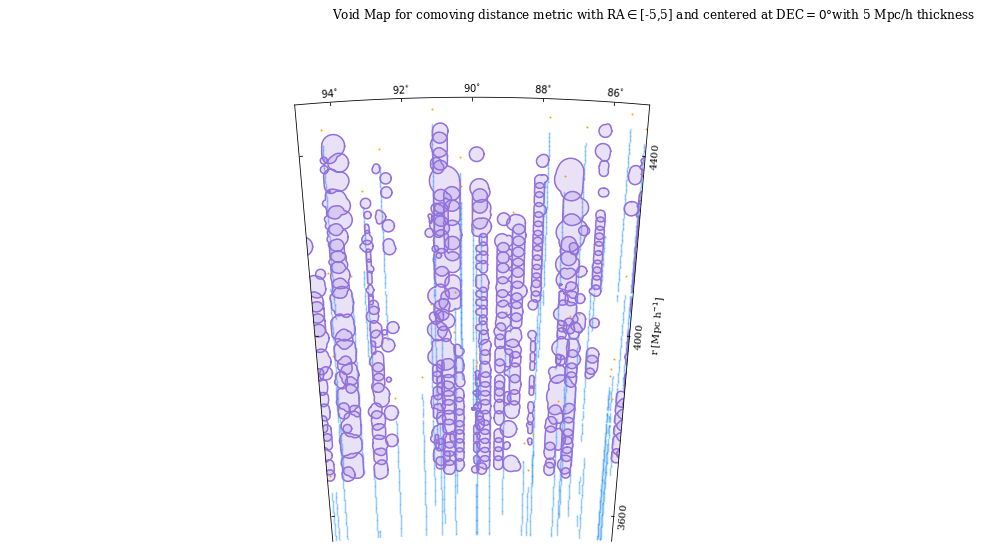

<Figure size 432x288 with 0 Axes>

In [23]:
pvfminezoom(0,5,1000,6) #1000,6

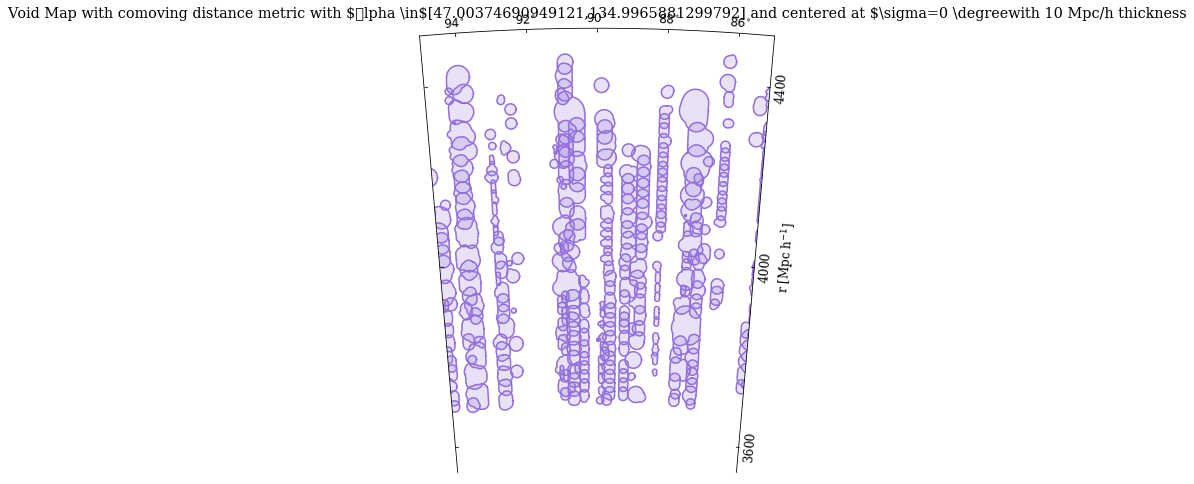

In [20]:
plt.rcParams.update({'font.size': 12})
plt.rc('text', usetex=False)                                                                        
#plt.rc('font', family='serif')  
dec,wdth,npc,chkdpth =0,5,1000,6
fig = plt.figure(1, figsize=(1600/96,800/96))
ax3, aux_ax3 = setup_axes3(fig, 111)
ra_min=min(dra)
ra_max=max(dra)
Cr = cint2(dec)
for i in range(len(vfr)):
    if np.sum(Cr[i])>0:
        Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
        aux_ax3.plot(Cra2,Cr2,color='mediumpurple')            #comoving plot
        aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='mediumpurple')  #comoving plot
    
plt.title('Void Map with comoving distance metric with $\alpha \in$['+str(ra_min)+','+str(ra_max)+'] and centered at $\sigma=0 \degree'+'with 10 Mpc/h thickness')
plt.show()

In [ ]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("Comoving Distance [Mpc/h]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

In [ ]:
fig = plt.figure(1, figsize=(1600/96,800/96))
ra_min, ra_max = -43, 45
cz_min, cz_max = min(deltaf['comoving']), max(quasars['comoving']) #32700
ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)
#ax3, aux_ax3 = setup_axes3(fig, 111)
plt.show()

In [ ]:
deltaf

In [ ]:
#plot VoidFinder voids
def pvfmine(dec,wdth,npc,chkdpth):
    fig = plt.figure(1, figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig, 111)
    Cr = cint2(dec)
    for i in range(len(vfr)):
        if np.sum(Cr[i])>0:
            Cr2,Cra2 = gcp2(vfr2[i],vfra2[i],Cr[i],npc,chkdpth)
            aux_ax3.plot(Cra2,Cr2,color='blue')            #comoving plot
            aux_ax3.fill(Cra2,Cr2,alpha=0.2,color='blue')  #comoving plot
        #Cr2,Cra2 = gcp3(vfx4[i],vfy4[i],vfz4[i],vfr2[i],vfrad2[i],vfdec2[i],dec,npc,chkdpth)
        #if len(Cr2)>0:
        #    aux_ax3.plot(Cra2,Cr2,color='blue')
        #    aux_ax3.fill(Cra2,Cr2,alpha=0.5,color='blue')
    gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2. #short for galaxy distance cut (:
    aux_ax3.scatter(dra[wflag_vf][gdcut],dr[wflag_vf][gdcut],color='k',s=1)
    gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    aux_ax3.scatter(dra[gflag_vf][gdcut],dr[gflag_vf][gdcut],color='red',s=1)
    #gdcut = (dr[wflag_vf]*np.sin((ddec[wflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[wflag_vf],dr[wflag_vf],color='k',s=1)
    #gdcut = (dr[gflag_vf]*np.sin((ddec[gflag_vf]-dec)*D2R))**2.<wdth**2.
    #aux_ax3.scatter(dra[gflag_vf],dr[gflag_vf],color='red',s=1)
    plt.show()

In [ ]:
pvfmine(0,5.,100,5) #1000,6

## Import data

In [ ]:
# Galaxy catalog
#galaxies = Table.read(galaxy_filename, format='ascii.commented_header', 
#                      include_names=['ra', 'dec', 'redshift', 'Rgal', 'vflag'])
deltaf = fits.open(deltafields_filename)  
deltaf=Table(deltaf[1].data)
deltaf['z'].name='redshift'
#rgal=Table.Column(1*np.ones(len(galaxies['ra'])), name='Rgal')
#galaxies.add_column(rgal)
vflag=Table.Column(np.zeros(len(deltaf['ra'])), name='vflag')
deltaf.add_column(vflag)
# Void catalog (detected voids, output of voidfinder)
voids = Table.read(void_filename, format='ascii.commented_header')

quasars = fits.open(quasars_filename)  
quasars=Table(quasars[1].data)

## z to comoving distance

In [ ]:
#z to comoving
#voidfinder.distance.z_to_comoving_dist

Omega_M = 0.3147
c = const.c.to('km/s').value
def Distance(z,omega_m = Omega_M,h = 1):
    dist = np.ones(len(z))
    H0 = 100*h
    for i,redshift in enumerate(z):
        a_start = 1/(1+redshift)
        I = quad(f,a_start,1,args=omega_m)
        dist[i] = I[0]*(c/H0)
    return dist

def f(a,omega_m = Omega_M):
     return 1/(np.sqrt(a*omega_m*(1+((1-omega_m)*a**3/omega_m))))

deltaf['comoving']= Distance(deltaf['redshift'],Omega_M,1)
quasars['comoving']= Distance(quasars['z'],Omega_M,1)
#Continue with voids['r']

## Shift ra's back for all

In [ ]:
deltaf['ra'] = deltaf['ra']-90
quasars['ra'] = quasars['ra']
voids['ra'] = voids['ra']-90

In [ ]:
len(voids)

In [ ]:
voids[0:5]

## Histogram for voids

In [ ]:
#Histogram of redshift
dpi=500
mpl.rcParams['figure.dpi']= dpi

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for maximal void radii',fontsize=14)                                         
plt.xlabel(r'radius [Mpc/h]',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   
                                                                                                    
plt.hist(voids['radius'] ,color='teal',bins=25)#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')

In [ ]:
#Histogram of redshift
dpi=500
mpl.rcParams['figure.dpi']= dpi

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for maximal void radii',fontsize=14)                                         
plt.xlabel(r'radius [Mpc/h]',fontsize=12)                                                                       
plt.ylabel(r'Number',fontsize=12)                                                                   
                                                                                                    
plt.hist(voids['radius'] ,log=True, color='teal',bins=25)#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')

In [ ]:
#Histogram of redshift
dpi=500
mpl.rcParams['figure.dpi']= dpi

plt.figure()                                                                                        
plt.rc('text', usetex=False)                                                                        
plt.rc('font', family='serif')                                                                      
                                                                                                    
plt.grid(True,ls='-.',alpha=.4)                                                                     
plt.title(r'Histogram for distance to voids',fontsize=14)                                         
plt.xlabel(r'r [Mpc/h]',fontsize=14)                                                                       
plt.ylabel(r'Number',fontsize=14)                                                                   
                                                                                                    
plt.hist(voids['r'] ,color='teal',bins=50)#,bins=range(int(min(galaxies['cz'])), int(max(galaxies['cz'])) + 0.1, 0.1), color='teal')                                                                   \
                                                                                                    
#plt.hist(2*np.pi*data[1].data['ra'], color='teal')                                                  
plt.show()                                                                                          
                                                                                                    
#plt.savefig('cz_distn.png')

## Function to set up axes

Following matplotlib demo : https://matplotlib.org/examples/axes_grid/demo_floating_axes.html

In [ ]:
def setup_axes3(fig, rect, ra0, ra1, cz0, cz1):
    
    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-90, 0)
    
    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180, 1)

    tr = tr_rotate + tr_scale + mpl.projections.PolarAxes.PolarTransform()
    
    grid_locator1 = angle_helper.LocatorHMS(4)
    tick_formatter1 = angle_helper.FormatterHMS()
    
    grid_locator2 = MaxNLocator(3)
    
    grid_helper = floating_axes.GridHelperCurveLinear(tr, extremes=(ra0, ra1, cz0, cz1),
                                                      grid_locator1=grid_locator1,
                                                      grid_locator2=grid_locator2,
                                                      tick_formatter1=tick_formatter1,
                                                      tick_formatter2=None)

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)
    
    # adjust axis
    ax1.axis['left'].set_axis_direction('bottom')
    
    ax1.axis['right'].set_axis_direction('top')
    
    ax1.axis['bottom'].set_visible(False)
    
    ax1.axis['top'].set_axis_direction("bottom")
    ax1.axis['top'].toggle(ticklabels=True, label=True)
    ax1.axis['top'].major_ticklabels.set_axis_direction("top")
    ax1.axis['top'].label.set_axis_direction("top")
    
    #ax1.axis['left'].major_ticklabels.set_axis_direction('right')
    ax1.axis["left"].label.set_text("Comoving Distance [Mpc/h]")
    
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch  
    ax1.patch.zorder = 0.9  

    return ax1, aux_ax

## Wedge plot

In [ ]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = 0, 0.005 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
deltaf_dec_cut = np.logical_and(deltaf['dec'] > d, 
                                deltaf['dec'] <= d+s)
deltaf_dec_slice = deltaf[deltaf_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = min(deltaf['comoving']), max(quasars['comoving']) #32700

deltaf_dist_boolean = np.logical_and(deltaf_dec_slice['comoving'] > cz_min, 
                                     deltaf_dec_slice['comoving'] <= cz_max)
deltaf_sample = deltaf_dec_slice[deltaf_dist_boolean]
################################################################################

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                                 quasars['dec'] <= d+s)
quasars_dec_slice = quasars[quasars_dec_cut]

quasars_dist_boolean = np.logical_and(quasars_dec_slice['comoving'] > cz_min, 
                                      quasars_dec_slice['comoving'] <= cz_max)
quasars_sample = quasars_dec_slice[quasars_dist_boolean]

################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################
max(void_sample['x_polar'])

In [ ]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -43, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(deltaf_sample['ra'], 
            deltaf_sample['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c='0.5', ms=3, zorder=1, label='Delta fields')
            #'.', c='0.5', zorder=1, label='Wall')
aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=1, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)

aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

In [ ]:
len(deltaf_sample)

In [ ]:
len(quasars_sample)

In [ ]:
len(void_sample)

In [ ]:
delta_less=deltaf_sample[deltaf_sample['delta']<-0.2]
delta_more=deltaf_sample[deltaf_sample['delta']>0.2]
delta_mid=deltaf_sample[deltaf_sample['delta']<=0.2]
delta_mid=delta_mid[delta_mid['delta']>=-0.2]

In [ ]:
print(len(delta_mid))
print(len(delta_more))
print(len(delta_less))

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -15, 15

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(delta_mid['ra'], 
            delta_mid['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.45,0.45,0.45), ms=3, zorder=2, label='$-0.2<\delta<0.2$')
            #'.', c='0.5', zorder=1, label='Wall')
    
aux_ax.plot(delta_more['ra'], 
            delta_more['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.8,0.8,0.8), ms=3, zorder=3, label='Underdense with $\delta>0.2$')
aux_ax.plot(delta_less['ra'], 
            delta_less['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.1,0.1,0.1), ms=3, zorder=1, label='Overdense with $\delta<-0.2$')

aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255),  zorder=4, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric with RA$\in$['+str(ra_min)+','+str(ra_max)+'] and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

#plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

In [ ]:
len(voids['r'])
quasars[0:5]

In [ ]:
len(quasars)

In [ ]:
len(deltaf)

In [ ]:
max(voids['r'])

In [ ]:
min(voids['r'])

In [ ]:
np.max(deltaf['delta'])

In [ ]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = 0, 0.05 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
deltaf_dec_cut = np.logical_and(deltaf['dec'] > d, 
                                deltaf['dec'] <= d+s)
deltaf_dec_slice = deltaf[deltaf_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = min(deltaf['comoving']), max(quasars['comoving']) #32700

deltaf_dist_boolean = np.logical_and(deltaf_dec_slice['comoving'] > cz_min, 
                                     deltaf_dec_slice['comoving'] <= cz_max)
deltaf_sample = deltaf_dec_slice[deltaf_dist_boolean]
################################################################################

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                                 quasars['dec'] <= d+s)
quasars_dec_slice = quasars[quasars_dec_cut]

quasars_dist_boolean = np.logical_and(quasars_dec_slice['comoving'] > cz_min, 
                                      quasars_dec_slice['comoving'] <= cz_max)
quasars_sample = quasars_dec_slice[quasars_dist_boolean]

################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################
max(void_sample['x_polar'])

In [ ]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -43, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(deltaf_sample['ra'], 
            deltaf_sample['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c='0.5', ms=3, zorder=1, label='Delta fields')
            #'.', c='0.5', zorder=1, label='Wall')
aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=1, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)

aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

In [ ]:
delta_less=deltaf_sample[deltaf_sample['delta']<-0.2]
delta_more=deltaf_sample[deltaf_sample['delta']>0.2]
delta_mid=deltaf_sample[deltaf_sample['delta']<=0.2]
delta_mid=delta_mid[delta_mid['delta']>=-0.2]

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -15, 15

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(delta_mid['ra'], 
            delta_mid['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.45,0.45,0.45), ms=3, zorder=2, label='$-0.2<\delta<0.2$')
            #'.', c='0.5', zorder=1, label='Wall')
    
aux_ax.plot(delta_more['ra'], 
            delta_more['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.8,0.8,0.8), ms=3, zorder=3, label='Underdense with $\delta>0.2$')
aux_ax.plot(delta_less['ra'], 
            delta_less['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.1,0.1,0.1), ms=3, zorder=1, label='Overdense with $\delta<-0.2$')

aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255),  zorder=4, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric with RA$\in$['+str(ra_min)+','+str(ra_max)+'] and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

#plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

## All of them 

In [ ]:
# 'd' is declination and 's' is the thickness of the declination slice
# Vary 'd' and 's' to get difference slices.
d,s = -1.25, 2.5 #s=2.5

# slice center, can use this for analysis since the slice thickness is very small.
slice_= d + 0.5*s


################################################################################
# Remove galaxies outside declination range
#-------------------------------------------------------------------------------
deltaf_dec_cut = np.logical_and(deltaf['dec'] > d, 
                                deltaf['dec'] <= d+s)
deltaf_dec_slice = deltaf[deltaf_dec_cut]
################################################################################


################################################################################
# Remove galaxies outside distance range
#-------------------------------------------------------------------------------
cz_min, cz_max = min(deltaf['comoving']), max(quasars['comoving']) #32700

deltaf_dist_boolean = np.logical_and(deltaf_dec_slice['comoving'] > cz_min, 
                                     deltaf_dec_slice['comoving'] <= cz_max)
deltaf_sample = deltaf_dec_slice[deltaf_dist_boolean]
################################################################################

quasars_dec_cut = np.logical_and(quasars['dec'] > d, 
                                 quasars['dec'] <= d+s)
quasars_dec_slice = quasars[quasars_dec_cut]

quasars_dist_boolean = np.logical_and(quasars_dec_slice['comoving'] > cz_min, 
                                      quasars_dec_slice['comoving'] <= cz_max)
quasars_sample = quasars_dec_slice[quasars_dist_boolean]

################################################################################
# Voids that intersect the slice
#-------------------------------------------------------------------------------
dec_intersect_cut = np.sin(np.abs(slice_ - voids['dec'])*np.pi/180)*voids['r'] <= voids['radius']
void_sample = voids[dec_intersect_cut]

# Radius of void at intersection
void_sample['radius_intersect'] = np.sqrt(void_sample['radius']**2 
                                          - (np.sin(np.abs(slice_ - void_sample['dec'])*np.pi/180)*void_sample['r'])**2)
################################################################################


################################################################################
# Transform hole centers from (ra, r) to (x, y)
#-------------------------------------------------------------------------------
void_sample['x_polar'] = void_sample['r']*np.cos(void_sample['ra']*np.pi/180 - 0.5*np.pi)
void_sample['y_polar'] = void_sample['r']*np.sin(void_sample['ra']*np.pi/180 - 0.5*np.pi)
################################################################################
max(void_sample['x_polar'])

In [ ]:
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -43, 45

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(deltaf_sample['ra'], 
            deltaf_sample['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c='0.5', ms=3, zorder=1, label='Delta fields')
            #'.', c='0.5', zorder=1, label='Wall')
aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255), ms=3, zorder=1, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)

aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)

ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

#plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)

In [ ]:
delta_less=deltaf_sample[deltaf_sample['delta']<-0.2]
delta_more=deltaf_sample[deltaf_sample['delta']>0.2]
delta_mid=deltaf_sample[deltaf_sample['delta']<=0.2]
delta_mid=delta_mid[delta_mid['delta']>=-0.2]

In [ ]:
dpi=500
mpl.rcParams['figure.dpi']= dpi
fig = plt.figure(figsize=(15,8))

# Range of RA to use in plot
ra_min, ra_max = -15, 15

ax, aux_ax = setup_axes3(fig, 111, ra_min, ra_max, cz_min, cz_max)


# Galaxies

#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 0], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 0], 
#            '.', c='0.5', ms=3, zorder=1, label='Wall')
#            #'.', c='0.5', zorder=1, label='Wall')
#aux_ax.plot(galaxies_sample['ra'][galaxies_sample['vflag'] == 1], 
#            galaxies_sample['cz'][galaxies_sample['vflag'] == 1], 
#            '.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
#            #'.', c=(1,135/255,123/255), zorder=2, label='Void')

aux_ax.plot(delta_mid['ra'], 
            delta_mid['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.45,0.45,0.45), ms=3, zorder=2, label='$-0.2<\delta<0.2$')
            #'.', c='0.5', zorder=1, label='Wall')
    
aux_ax.plot(delta_more['ra'], 
            delta_more['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.8,0.8,0.8), ms=3, zorder=3, label='Underdense with $\delta>0.2$')
aux_ax.plot(delta_less['ra'], 
            delta_less['comoving'], 
            #'.', c=(1,135/255,123/255), ms=3, zorder=2, label='Void')
            '.', c=(0.1,0.1,0.1), ms=3, zorder=1, label='Overdense with $\delta<-0.2$')

aux_ax.plot(quasars_sample['ra'], 
            quasars_sample['comoving'], 
            '.', c=(1,135/255,123/255),  zorder=4, label='Quasars')
  
# Voids
holes = [plt.Circle((x,y), radius=r, transform=aux_ax.transData._b, fill=False, ec='b') 
         for x,y,r in zip(void_sample['x_polar'], void_sample['y_polar'], void_sample['radius_intersect'])]
for hole in holes:
    aux_ax.add_artist(hole)
'''
aux_ax.scatter(void_sample['ra'], void_sample['r']*100, edgecolors='b', 
               s=void_sample['radius_intersect']*100, facecolors='none', 
               linewidth=1.5, zorder=3)
'''
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Void Map with comoving distance metric with RA$\in$['+str(ra_min)+','+str(ra_max)+'] and DEC$\in$['+str(d)+','+str(d+s)+']')
#plt.text(s='DEC $\in$[(%s)]'%(d)) #'Sigmoid(%s)'%(a) #plt.text('DEC $\in$[(%s),(%s)]'%(d)%(d+s))
#plt.text('DEC'+str(d)+','+str(d+s))
mpl.rc('font', size=10)

plt.tight_layout();

#plt.savefig('DR16_deltafields_comoving.eps', format='eps', dpi=300)